# Environment
## Обучал локально, но в коллабе запуститься.

In [ ]:
!nvidia-smi -L

In [ ]:
! pip install gdown lmdb opencv-python matplotlib torch tqdm

In [ ]:
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Dataset


Ссылка на датасет на моем гугл-диске (если слишком часто скачивать, на день заблокируется)

In [ ]:
! gdown https://drive.google.com/file/d/13vtpN31r2imMIDhHt2lhksXhRgsKJhRr/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=13vtpN31r2imMIDhHt2lhksXhRgsKJhRr
From (redirected): https://drive.google.com/uc?id=13vtpN31r2imMIDhHt2lhksXhRgsKJhRr&confirm=t&uuid=22f2b43d-961e-4230-aeb7-2a79f90ff9ff
To: /root/course_intro_ocr/task2/lmdb.zip
100%|███████████████████████████████████████| 10.1G/10.1G [01:16<00:00, 132MB/s]


In [ ]:
#! apt-get install unzip
! unzip 'lmdb.zip' -d 'lmdb_unzip'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 175 kB of archives.
After this operation, 386 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]
Fetched 175 kB in 0s (1058 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 17282 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-26ubuntu3.2_amd64.deb ...
Unpacking unzip (6.0-26ubuntu3.2) ...
Setting up unzip (6.0-26ubuntu3.2) ...
Archive:  lmdb.zip
  inflating: lmdb_unzip/lmdb/test.lmdb  
  inflating: lmdb_unzip/lmdb/train.lmdb  


In [2]:
import lmdb

In [3]:
import os

from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = "lmdb_unzip/lmdb"
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [4]:
import cv2
import numpy as np

In [5]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [6]:
train_helper, val_helper = train_helper.train_val_split()

In [7]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [8]:
img, label = train_helper.get_item(42)

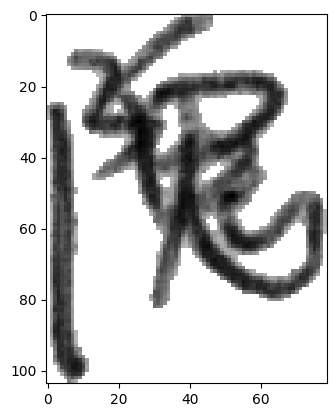

In [9]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

## Поделаем аугментацию

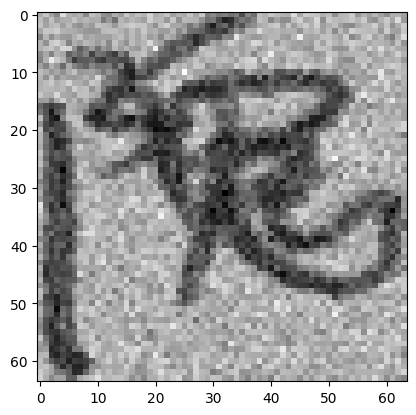

In [10]:
resized = (cv2.resize(img, (64, 64)) - 127.5) / 255.
gauss = np.random.normal(0,0.15,(64, 64))
plt.imshow(resized + gauss, cmap='gray')

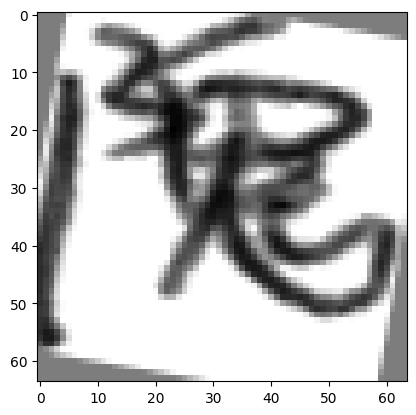

In [11]:
image_center = tuple(np.array(resized.shape[1::-1]) / 2)
angle = -10
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
result = cv2.warpAffine(resized, rot_mat, resized.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.imshow(result, cmap='gray')

С вероятностью 0.5 к изображению добавляется случайный шум, с вероятностью 0.5 независимо поворот c углом $\alpha \sim \mathbb{U}[-15, 15]$

In [12]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper, augment=False):
        self.helper = helper
        self.augment = augment

    def __len__(self):
        return self.helper.size()

    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        reshaped = (cv2.resize(img, (64, 64)) - 127.5) / 255.

        if self.augment:
          if np.random.randint(2):
            noise = np.random.normal(0,0.15,(64, 64))
            reshaped += noise
          if np.random.randint(2):
            image_center = tuple(np.array(reshaped.shape[1::-1]) / 2)
            angle = np.random.rand() * 30 - 15 # random from [-15, 15]
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            reshaped = cv2.warpAffine(reshaped, rot_mat, reshaped.shape[1::-1], flags=cv2.INTER_LINEAR)

        return reshaped, label

In [13]:
train_dataset = HWDBDataset(train_helper, augment=True)
val_dataset = HWDBDataset(val_helper, augment=False)

# Models



In [14]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm

    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())

            n_all += len(classes)

    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())

        optim.zero_grad()
        loss.backward()
        optim.step()

## Loss


Пробовал спользовал ArcFaceLoss. Однако качество моделей сильно проседало. Если стандартная кросс-энтропия давала 80->90+ accuracy, то ArcFace 65->75. Пробовал перебирать парметры AdamW и самого лосса.
(Дополнительные нормировки в моделях я убрал)

Сама реализация лосса приведена ниже.

В реализации, аналогично многим другим, используется стабилизация в виде замены $cos(\theta + m)$ на $\cos(\theta) - m \sin m$ при больших $\theta$.  (Это делает лосс убывающим при всех возможных углах).

In [85]:
from losses.arc_face import ArcFaceLoss

In [86]:
y_true = torch.tensor([1, 2, 2], dtype=int)
y_pred = torch.tensor([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]])
ArcFaceLoss(3)(y_pred, y_true)

tensor(31.1830)

## CNN

In [101]:
from models.cnn import MyCNN

In [102]:
model = MyCNN(train_helper.vocabulary.num_classes())

In [103]:
model.eval()
model(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 1, 64, 64))

tensor([[ 0.1523, -0.1882,  0.3728,  ..., -0.4210, -0.2909, -0.4697]],
       grad_fn=<MmBackward0>)

In [104]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

model = model.cuda()

optim = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2)
#loss_fn = ArcFaceLoss(train_helper.vocabulary.num_classes())

cnn_accuracy = list()

for epoch in range(20):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    cnn_accuracy.append(accuracy)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'cnn/epoch{epoch}.pth')

Epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:04<00:00,  4.92it/s]


accuracy: 0.8426162216165148
Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:02<00:00,  5.08it/s]


accuracy: 0.8851582897539438
Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:02<00:00,  5.01it/s]


accuracy: 0.8959819053100406
Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:03<00:00,  4.99it/s]


accuracy: 0.9039153967754096
Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:02<00:00,  5.02it/s]


accuracy: 0.9084514798893593
Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:02<00:00,  5.00it/s]


accuracy: 0.9111445853222652
Epoch 6:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:00<00:00,  5.19it/s]


accuracy: 0.9134762313278282
Epoch 7:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [01:03<00:00,  4.97it/s]


accuracy: 0.9143154997835897
Epoch 8:


100%|███████████████████████████████| 315/315 [01:00<00:00,  5.18it/s]


accuracy: 0.9168348564788887
Epoch 9:


100%|███████████████████████████████| 315/315 [01:02<00:00,  5.02it/s]


accuracy: 0.9174228097963262
Epoch 10:


100%|███████████████████████████████| 315/315 [01:01<00:00,  5.11it/s]


accuracy: 0.9171606353619015
Epoch 11:


  6%|█▋                            | 289/5036 [00:28<07:41, 10.29it/s]


KeyboardInterrupt: 

## Vision Transformer

In [ ]:
class MyViT(nn.Module):
  def __init__(self, patch_kernel, dim, layers, heads, ffn_dim, n_classes):
    super(MyViT, self).__init__()

    assert 64 % patch_kernel == 0

    self.patching = nn.Unfold((patch_kernel, patch_kernel), stride=patch_kernel//2)
    self.projection = nn.Linear(patch_kernel ** 2, dim)

    self.tag_token = nn.Parameter(torch.zeros(dim))
    split_size = 64 // patch_kernel
    n_pos_embedding_tokens = (split_size + (split_size -1))**2
    self.pos_embedding = nn.Parameter((torch.rand(n_pos_embedding_tokens, dim)) - 0.5)

    layer = nn.TransformerEncoderLayer(dim, heads, ffn_dim,
                                       batch_first=True, norm_first=True)
    self.encoder = nn.TransformerEncoder(layer, num_layers=layers)
    self.out_layer = nn.Linear(dim, n_classes)

  def forward(self, x):
    x = self.patching(x) # [batch : kernel * kernel : tokens]
    x = torch.movedim(x, 1, 2)
    tokens = self.pos_embedding + self.projection(x) # [batch : tokens : dim]

    tag_tokens = torch.stack([self.tag_token] * len(tokens), dim=0)
    tag_tokens = torch.unsqueeze(tag_tokens, 1) # [batch : 1 : dim]
    tokens = torch.cat([tag_tokens, tokens], 1)

    out = self.encoder(tokens)[:, 0]
    return self.out_layer(out)


In [ ]:
vit = MyViT(16, 64, 6, 4, 1024, train_helper.vocabulary.num_classes())

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
vit.eval()
vit(torch.tensor(train_dataset[0][0], dtype=torch.float32).view(1, 1, 64, 64))

tensor([[-0.8958, -0.6806, -0.4136,  ...,  0.8929,  0.9425,  2.3412]],
       grad_fn=<AddmmBackward0>)

In [ ]:
optim = torch.optim.AdamW(vit.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

vit.cuda()

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=8)

vit_accuracy = list()

for epoch in range(20):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, vit, optim, loss_fn)
    accuracy = run_validation(val_loader, vit)
    vit_accuracy.append(accuracy)
    print(f'accuracy: {accuracy}')
    torch.save(vit.state_dict(), f'vit/epoch{epoch}.pth')

Epoch 0:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.48it/s]


accuracy: 0.8554720768714058
Epoch 1:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.47it/s]


accuracy: 0.8761140474303027
Epoch 2:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.41it/s]


accuracy: 0.89756270855666
Epoch 3:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.47it/s]


accuracy: 0.9014689524967848
Epoch 4:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.47it/s]


accuracy: 0.9048741174882758
Epoch 5:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.46it/s]


accuracy: 0.9061151798997532
Epoch 6:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.47it/s]


accuracy: 0.9095141395791868
Epoch 7:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.38it/s]


accuracy: 0.9073236644229292
Epoch 8:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:36<00:00, 17.42it/s]


accuracy: 0.9099407547831321
Epoch 9:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:35<00:00, 17.54it/s]

accuracy: 0.9073639989513023


# Merging

In [ ]:
class ModelSum(nn.Module):
  def __init__(self, model1, model2, gamma):
    super().__init__()
    self.model1 = model1
    self.model2 = model2
    self.gamma = gamma

  def forward(self, x):
    out1 = nn.functional.softmax(self.model1(x), -1)
    out2 = nn.functional.softmax(self.model2(x), -1)

    return self.gamma * out1 + (1 - self.gamma) * out2

In [ ]:
best_cnn = MyNet(n_classes=train_helper.vocabulary.num_classes())
best_vit = MyViT(16, 64, 6, 4, 1024, train_helper.vocabulary.num_classes())

cnn_epoch = np.argmax(np.array(cnn_accuracy))
vit_epoch = np.argmax(np.array(vit_acuracy))

print(f'best cnn epoch = {cnn_epoch}')
print(f'best vit epoch = {vit_epoch}')

best_cnn.load_state_dict(torch.load(f'cnn/epoch{cnn_epoch}.pth'))
best_vit.load_state_dict(torch.load(f'vit/epoch{vit_epoch}.pth'))

best_cnn.to('cuda')
best_vit.to('cuda')

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


MyViT(
  (patching): Unfold(kernel_size=(16, 16), dilation=1, padding=0, stride=8)
  (projection): Linear(in_features=256, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (out_layer): Linear(in_features=64, out_features=7330, bias=True)
)

In [ ]:
for gamma in torch.tensor(np.linspace(0, 1, 10)):
  print(f'gamma = {gamma}')
  accuracy = run_validation(val_loader, ModelSum(best_cnn, best_vit, gamma))
  print(f'accuracy: {accuracy}')

gamma = 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.17it/s]


accuracy: 0.9099407547831321
gamma = 0.1111111111111111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.18it/s]


accuracy: 0.9150213540301175
gamma = 0.2222222222222222


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.21it/s]


accuracy: 0.9202586374065519
gamma = 0.3333333333333333


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.22it/s]


accuracy: 0.9251685905719591
gamma = 0.4444444444444444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.21it/s]


accuracy: 0.9295728108046893
gamma = 0.5555555555555556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.19it/s]


accuracy: 0.9329748731401516
gamma = 0.6666666666666666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.21it/s]


accuracy: 0.934488969282154
gamma = 0.7777777777777777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.18it/s]


accuracy: 0.933432514904384
gamma = 0.8888888888888888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:38<00:00,  8.19it/s]


accuracy: 0.9282743492566812
gamma = 1.0


  7%|████████████                                                                                                                                                          | 23/315 [00:03<00:44,  6.54it/s]


KeyboardInterrupt: 

### Evaluation

In [ ]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [ ]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

In [ ]:
preds = []
model = ModelSum(best_cnn, best_vit, 0.77)
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:46<00:00,  8.24it/s]


In [ ]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [ ]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9149812690673682